In [13]:
import librosa
import python_speech_features as psf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision.all import *
from PIL import Image 

In [149]:
train = pd.read_csv('Train.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [15]:
def get_fns(_):
    return train['fn']

def get_y(fn):
    return train.loc[train.fn == fn].label.values[0]

In [16]:
path = Path("/home/kkalyan/agri-split/mel")

In [78]:
im = Image.open(path.ls()[7]); im.shape

(249, 221)

In [123]:
np.array(im).shape; mean = np.mean(np.array(im), axis=0)
mean.shape

(221, 4)

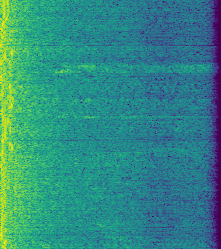

In [122]:
im

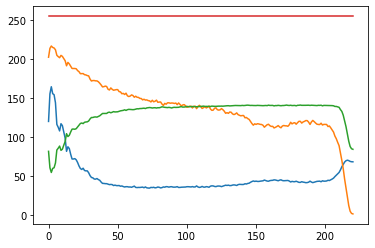

In [124]:
plt.plot(mean)
plt.show()

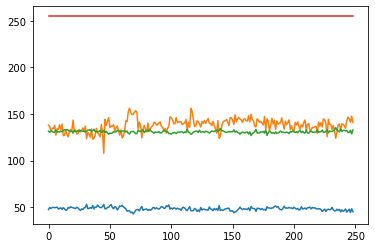

In [125]:
mean = np.mean(np.array(im), axis=1)
plt.plot(mean)
plt.show()

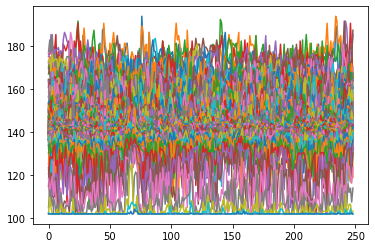

In [126]:
mean = np.mean(np.array(im), axis=2)
plt.plot(mean)
plt.show()

In [108]:
w, h = im.shape
sp = np.pad(np.array(im), [(1, 0), (1, 0), (0,0)],  mode = 'median')

In [114]:
sp.shape

(250, 222, 4)

In [91]:
a = np.array([[1, 2],[3, 4]]);a

array([[1, 2],
       [3, 4]])

In [97]:
np.pad(a,((2, 0), (1, 0)), mode = 'median')

array([[2, 2, 3],
       [2, 2, 3],
       [2, 1, 2],
       [4, 3, 4]])

In [79]:
k = np.pad(im, ([0,40], [0,40], [0,0]), 'median')

In [135]:
def get_x(fn):

    # Use our function from earlier
    spectrogram = Image.open(fn)
    spectogram_mean = np.mean(np.array(im), axis=-1)
    
    # Pad to make sure it is 512 x 512
    w, h = spectogram_mean.shape
    spectrogram = np.pad(spectogram_mean, [(0, 512-w), (0, 512-h)], mode = 'median')
    
    # Scale to (0, 255)
    spectrogram  -= spectrogram.min()
    spectrogram *= 255.0/spectrogram.max()

    # Make it uint8
    im_arr = np.array(spectrogram, np.uint8)
    

    # Make it rgb (hint - some fun tricks you can do here!)
    r = im_arr
    g = im_arr
    b = im_arr

    return np.stack([r, g, b], axis=-1)

In [136]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_fns,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.1),
    batch_tfms=aug_transforms(do_flip=False, p_affine=0, size=224) 
)

In [161]:
train["fn"] = train["fn"].apply(lambda x: path/Path(str(x.split("/")[-1])+".png"))
train.head()

,fn,label,fn_1
0,/home/kkalyan/agri-split/mel/IV38R7F.wav.png,akawuka,/home/kkalyan/agri-split/mel/IV38R7F.wav.png
1,/home/kkalyan/agri-split/mel/KM4SKWT.wav.png,banana,/home/kkalyan/agri-split/mel/KM4SKWT.wav.png
2,/home/kkalyan/agri-split/mel/F5POSU9.wav.png,obulwadde,/home/kkalyan/agri-split/mel/F5POSU9.wav.png
3,/home/kkalyan/agri-split/mel/MMVDXG2.wav.png,nnyaanya,/home/kkalyan/agri-split/mel/MMVDXG2.wav.png
4,/home/kkalyan/agri-split/mel/9TVM96F.wav.png,pampu,/home/kkalyan/agri-split/mel/9TVM96F.wav.png


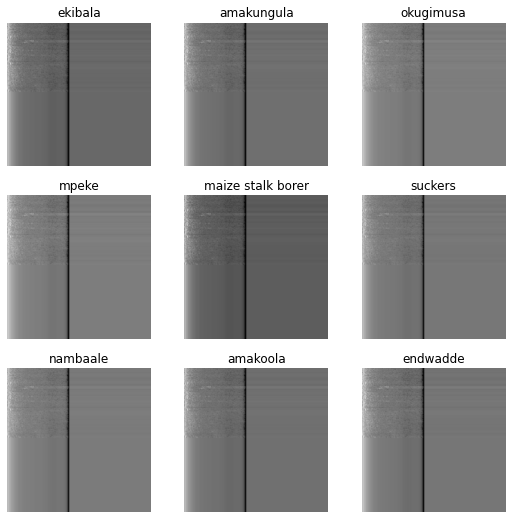

In [163]:
dls = dblock.dataloaders(path, bs=32)
dls.show_batch()

In [166]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, top_k_accuracy])
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,7.015613,7.879519,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.697588,5.784947,0.000000,0.009091,00:04
1,6.654747,5.461962,0.009091,0.018182,00:03
2,6.563119,5.411475,0.000000,0.009091,00:04


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=6.309573450380412e-07)

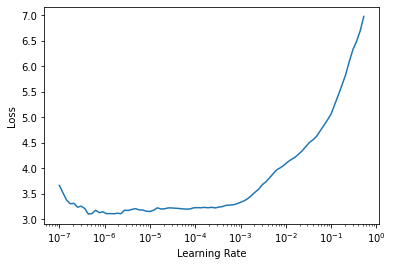

In [18]:
learn.lr_find(suggestions=True)

In [19]:
learn.fit_one_cycle(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.190671,5.173702,0.054545,0.136364,00:18
1,3.121170,5.292143,0.045455,0.118182,00:18
2,3.014237,5.291515,0.027273,0.127273,00:18
3,3.006058,5.204118,0.027273,0.145455,00:18
4,2.885885,5.511030,0.036364,0.081818,00:18
5,2.555433,5.145837,0.072727,0.209091,00:18
6,2.247273,5.126091,0.036364,0.218182,00:18
7,1.958268,5.187501,0.063636,0.145455,00:18
8,1.647867,4.948631,0.081818,0.218182,00:18
9,1.372178,4.875313,0.081818,0.209091,00:18


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.3182567499825382e-06)

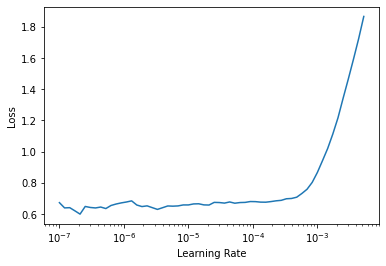

In [20]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [22]:
learn.fit_one_cycle(3, slice(1e-7))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.667874,4.884436,0.090909,0.200000,00:18
1,0.651558,4.912364,0.090909,0.218182,00:18
2,0.648927,4.897904,0.109091,0.209091,00:18
3,0.641929,4.918287,0.090909,0.209091,00:18
4,0.639070,4.894212,0.090909,0.190909,00:18
5,0.650807,4.874516,0.090909,0.209091,00:18
6,0.687981,4.901456,0.090909,0.200000,00:18
7,0.672815,4.907608,0.100000,0.209091,00:18
8,0.661411,4.910586,0.100000,0.200000,00:18
9,0.643661,4.899327,0.090909,0.200000,00:18


In [26]:
tdl = learn.dls.test_dl(ss['fn'].values, order=True) # Create a test dataloader
test_preds, test_labels = learn.get_preds(dl=tdl) # Make the predictions

In [27]:
dls.vocab # The class names

(#193) ['Pump','Spinach','abalimi','afukirira','agriculture','akammwanyi','akamonde','akasaanyi','akatunda','akatungulu'...]

In [28]:
ss.to_csv('Submission_logn.csv', index=False)